In [2]:
import pandas as pd
import numpy as np
import time
import spacy
import random
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext import data 
import torchtext
from nltk.tokenize.treebank import TreebankWordDetokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Setting device on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

torch.backends.cudnn.deterministic = True

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.7/dist-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


#### Loading Dataset - Preprocessing on the Tweets

In [4]:
datas_dir = r'/content/drive/My Drive/Courses/DeepLearning/HW03/Q01/Datas/train.csv'
destination_folder = '/content/drive/My Drive/Courses/DeepLearning/HW03/Q01/Datas'

In [5]:
df = pd.read_csv(datas_dir, engine="python", header=None)
df.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df[0]=df[0].replace(to_replace=4,value=1)
df[0].value_counts()

1    800000
0    800000
Name: 0, dtype: int64

In [7]:
df.sample(200000).to_csv("sentiment140-small.csv", header=None, index=None)

In [8]:
TEXT = torchtext.legacy.data.Field(tokenize='spacy', lower=True, include_lengths= True)
LABEL = torchtext.legacy.data.LabelField(dtype=torch.float)

fields = [('label', LABEL), ('id',None),('date',None),('query',None),
      ('name',None), ('text', TEXT),('category',None)]

dataset = torchtext.legacy.data.TabularDataset(
        path="sentiment140-small.csv",
        format="CSV",
        fields=fields,
        skip_header=False)

(train_data, test_data, valid_data) = dataset.split(split_ratio=[0.8,0.1,0.1])

print("Number of train data: {}".format(len(train_data)))
print("Number of test data: {}".format(len(test_data)))
print("Number of validation data: {}".format(len(valid_data)))

Number of train data: 160000
Number of test data: 20000
Number of validation data: 20000


In [9]:
# An example from the training set
print(vars(train_data.examples[0]))

{'label': '0', 'text': ['@yagulmez', 'i', 'missed', 'the', 'game']}


#### Building Vocabulary

In [10]:
MAX_VOCAB_SIZE = 50000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

TEXT.vocab.freqs.most_common(10)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:14<00:00, 27708.68it/s]


[('i', 99547),
 ('!', 90778),
 ('.', 80825),
 (' ', 58604),
 ('to', 56300),
 ('the', 52229),
 (',', 48269),
 ('a', 38053),
 ('my', 31449),
 ('and', 30697)]

In [11]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    device = device,
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True)

#### Helper Functions

In [12]:
def print_confusion_matrix(model, iterator, num_classes):
  cls_true = []
  cls_pred = []

  with torch.no_grad(): 

    for batch in iterator:

        if batch.label.shape[0]!=128:
          continue
        text, text_lengths = batch.text
        text_lengths = text_lengths.cpu()
        predictions = model(text, text_lengths).squeeze(1)
        preds = torch.round(torch.sigmoid(predictions))
        cls_true.append(batch.label)
        cls_pred.append(preds)
      
    cls_true = torch.FloatTensor(torch.stack(cls_true).view(-1).cpu())
    cls_pred = torch.FloatTensor(torch.stack(cls_pred).view(-1).cpu())
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    plt.clim(0, 10000) 
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def batch_accuracy(predictions, label):

    preds = torch.round(torch.sigmoid(predictions))
    correct = (preds == label).float()
    accuracy = correct.sum() / len(correct)

    return accuracy

def timer(start_time, end_time):

    time = end_time - start_time
    mins = int(time / 60)
    secs = int(time - (mins * 60))

    return mins, secs

def train(model, iterator, optimizer, criterion):

    training_loss = 0.0
    training_acc = 0.0
    
    model.train()
     
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        text_lengths = text_lengths.cpu()
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)

        accuracy = batch_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        training_loss += loss.item()
        training_acc += accuracy.item()

    return training_loss / len(iterator), training_acc / len(iterator)

def evaluate(model, iterator, criterion):

    eval_loss = 0.0
    eval_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            text_lengths = text_lengths.cpu()
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            accuracy = batch_accuracy(predictions, batch.label)

            eval_loss += loss.item()
            eval_acc += accuracy.item()
        
    return eval_loss / len(iterator), eval_acc / len(iterator)

#### Model - LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                                                  bidirectional=bidirectional,
                                                  dropout=dropout)

        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text)) 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))


        return self.predictor(hidden)

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model_1D = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

BIDIRECTIONAL = True
model_2D = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [15]:
pretrained_embeddings = TEXT.vocab.vectors
model_1D.embedding.weight.data.copy_(pretrained_embeddings)
model_2D.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.5107, -0.2283, -0.3392,  ...,  1.1965,  0.5563, -1.5424],
        [-1.0828,  0.2196, -0.7311,  ..., -0.5476,  0.9732,  0.2092],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.5709, -0.5875,  0.1372,  ..., -0.3089,  0.5500,  2.2880],
        [-0.0966, -0.6294, -1.5139,  ...,  0.6840,  0.3758, -0.2802],
        [-0.8884, -1.0695,  0.1086,  ..., -0.8364,  0.5210, -1.4874]])

In [16]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model_1D.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_1D.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


model_2D.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model_2D.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Training the Model - 1 Directional

In [17]:
optimizer = optim.Adam(model_1D.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model_1D.to(device)
criterion = criterion.to(device)

In [18]:
NUM_EPOCHS = 10

best_valid_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_1D, train_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model_1D, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Epoch 1:
	 Total Time: 0m 10s
	 Train Loss 0.52 | Train Accuracy: 74.01%
	 Validation Loss 0.43 | Validation Accuracy: 80.22%
Epoch 2:
	 Total Time: 0m 10s
	 Train Loss 0.43 | Train Accuracy: 80.08%
	 Validation Loss 0.41 | Validation Accuracy: 81.79%
Epoch 3:
	 Total Time: 0m 10s
	 Train Loss 0.4 | Train Accuracy: 82.17%
	 Validation Loss 0.39 | Validation Accuracy: 82.72%
Epoch 4:
	 Total Time: 0m 10s
	 Train Loss 0.37 | Train Accuracy: 83.48%
	 Validation Loss 0.38 | Validation Accuracy: 83.1%
Epoch 5:
	 Total Time: 0m 10s
	 Train Loss 0.35 | Train Accuracy: 84.6%
	 Validation Loss 0.38 | Validation Accuracy: 83.1%
Epoch 6:
	 Total Time: 0m 10s
	 Train Loss 0.34 | Train Accuracy: 85.44%
	 Validation Loss 0.38 | Validation Accuracy: 83.52%
Epoch 7:
	 Total Time: 0m 10s
	 Train Loss 0.32 | Train Accuracy: 86.12%
	 Validation Loss 0.38 | Validation Accuracy: 83.69%
Epoch 8:
	 Total Time: 0m 10s
	 Train Loss 0.31 | Train Accuracy: 86.82%
	 Validation Loss 0.39 | Validation Accuracy: 83.

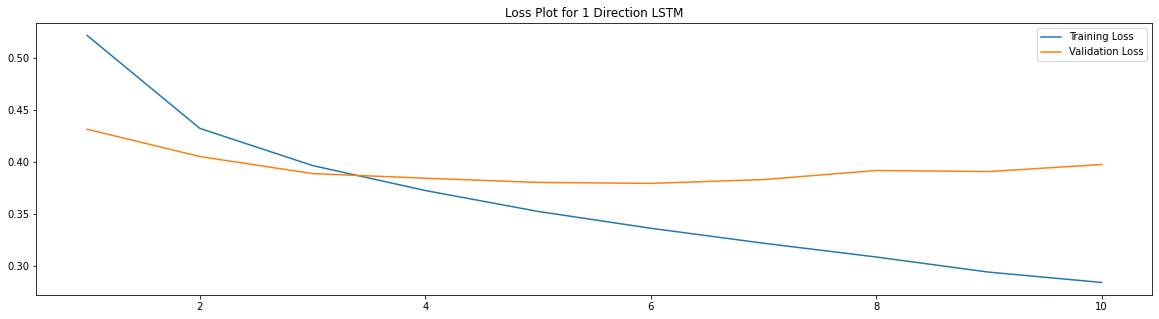

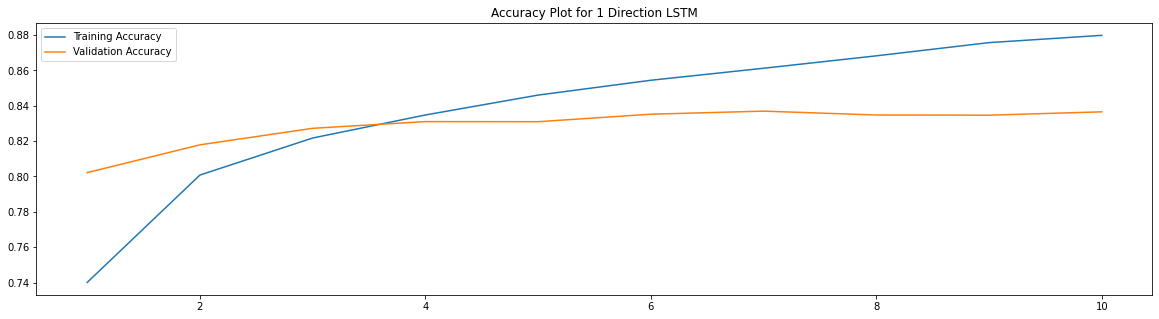

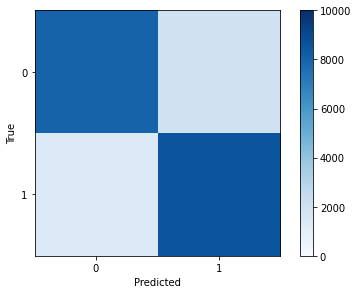

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_losses, label='Validation Loss')
plt.title('Loss Plot for 1 Direction LSTM')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_accs, label='Training Accuracy')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_accs, label='Validation Accuracy')
plt.title('Accuracy Plot for 1 Direction LSTM')
plt.legend()
plt.show()

print_confusion_matrix(model_1D, test_iterator, 2)

#### Training the Model - BiDirectional

In [20]:
optimizer = optim.Adam(model_2D.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model_2D.to(device)
criterion = criterion.to(device)

In [21]:
NUM_EPOCHS = 10

best_valid_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model_2D, train_iterator, optimizer, criterion)
    
    valid_loss, valid_acc = evaluate(model_2D, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))



Epoch 1:
	 Total Time: 0m 14s
	 Train Loss 0.51 | Train Accuracy: 74.63%
	 Validation Loss 0.43 | Validation Accuracy: 80.84%
Epoch 2:
	 Total Time: 0m 14s
	 Train Loss 0.43 | Train Accuracy: 80.5%
	 Validation Loss 0.4 | Validation Accuracy: 82.16%
Epoch 3:
	 Total Time: 0m 14s
	 Train Loss 0.39 | Train Accuracy: 82.4%
	 Validation Loss 0.38 | Validation Accuracy: 82.93%
Epoch 4:
	 Total Time: 0m 14s
	 Train Loss 0.37 | Train Accuracy: 83.74%
	 Validation Loss 0.38 | Validation Accuracy: 83.35%
Epoch 5:
	 Total Time: 0m 15s
	 Train Loss 0.35 | Train Accuracy: 84.81%
	 Validation Loss 0.38 | Validation Accuracy: 83.49%
Epoch 6:
	 Total Time: 0m 15s
	 Train Loss 0.33 | Train Accuracy: 85.62%
	 Validation Loss 0.39 | Validation Accuracy: 83.63%
Epoch 7:
	 Total Time: 0m 15s
	 Train Loss 0.32 | Train Accuracy: 86.4%
	 Validation Loss 0.38 | Validation Accuracy: 83.38%
Epoch 8:
	 Total Time: 0m 14s
	 Train Loss 0.3 | Train Accuracy: 87.11%
	 Validation Loss 0.39 | Validation Accuracy: 83.5

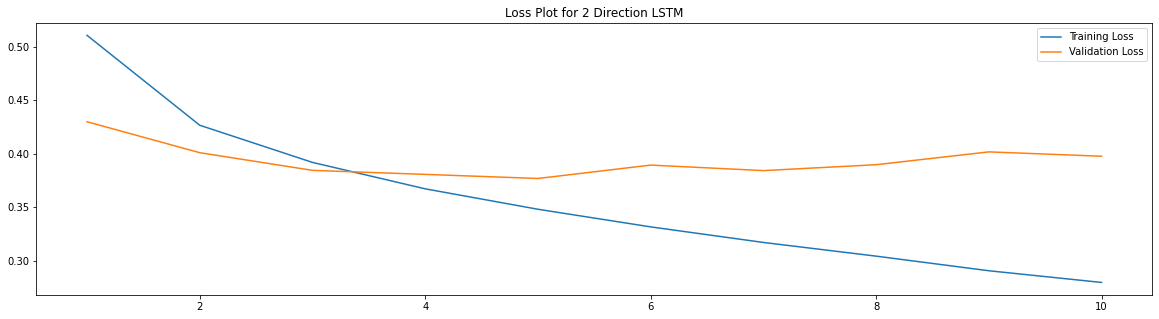

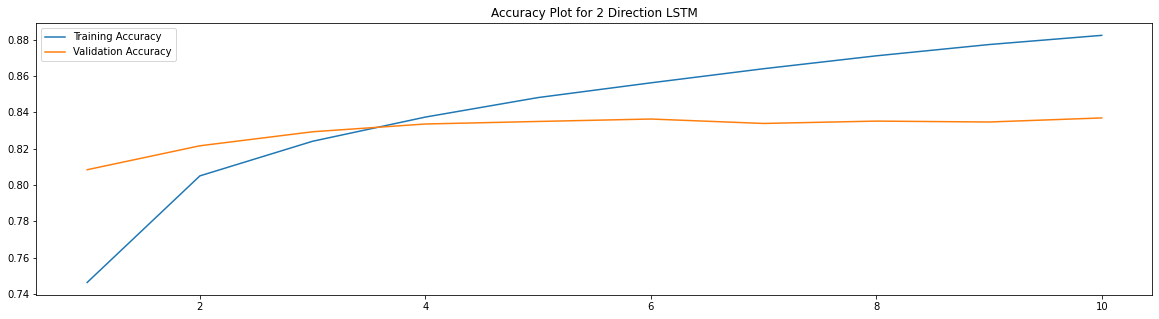

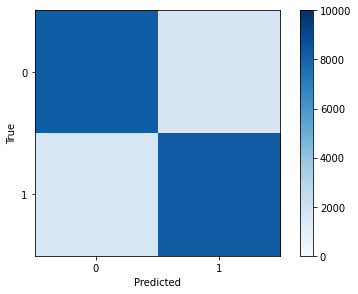

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_losses, label='Validation Loss')
plt.title('Loss Plot for 2 Direction LSTM')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_accs, label='Training Accuracy')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_accs, label='Validation Accuracy')
plt.title('Accuracy Plot for 2 Direction LSTM')
plt.legend()
plt.show()

print_confusion_matrix(model_2D, test_iterator, 2)

#### Model - LSTM Pyramid

In [23]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                                                  bidirectional=bidirectional,
                                                  dropout=dropout)

        self.predictor = nn.Linear(hidden_dim*2, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text)) 
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)

        raw_output = packed_embedded
        new_hidden = []
        raw_outputs = []
        outputs = []
        hidden = None
        for l, rnn in enumerate(range(4)):
            raw_output, (hidden, cell) = self.encoder(raw_output)
            
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.predictor(hidden)

In [24]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [25]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.5107, -0.2283, -0.3392,  ...,  1.1965,  0.5563, -1.5424],
        [-1.0828,  0.2196, -0.7311,  ..., -0.5476,  0.9732,  0.2092],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [ 0.5709, -0.5875,  0.1372,  ..., -0.3089,  0.5500,  2.2880],
        [-0.0966, -0.6294, -1.5139,  ...,  0.6840,  0.3758, -0.2802],
        [-0.8884, -1.0695,  0.1086,  ..., -0.8364,  0.5210, -1.4874]])

In [26]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

#### Training the Model - Pyramid

In [27]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [28]:
NUM_EPOCHS = 20

best_valid_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    train_accs.append(train_acc)
    val_accs.append(valid_acc)

    end_time = time.time()

    mins, secs = timer(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model-small.pt')

    print("Epoch {}:".format(epoch+1))
    print("\t Total Time: {}m {}s".format(mins, secs))
    print("\t Train Loss {} | Train Accuracy: {}%".format(round(train_loss, 2), round(train_acc*100, 2)))
    print("\t Validation Loss {} | Validation Accuracy: {}%".format(round(valid_loss, 2), round(valid_acc*100, 2)))

Epoch 1:
	 Total Time: 0m 19s
	 Train Loss 0.58 | Train Accuracy: 65.85%
	 Validation Loss 0.45 | Validation Accuracy: 79.85%
Epoch 2:
	 Total Time: 0m 19s
	 Train Loss 0.44 | Train Accuracy: 79.68%
	 Validation Loss 0.42 | Validation Accuracy: 81.41%
Epoch 3:
	 Total Time: 0m 19s
	 Train Loss 0.41 | Train Accuracy: 81.65%
	 Validation Loss 0.41 | Validation Accuracy: 81.8%
Epoch 4:
	 Total Time: 0m 19s
	 Train Loss 0.39 | Train Accuracy: 82.8%
	 Validation Loss 0.4 | Validation Accuracy: 82.66%
Epoch 5:
	 Total Time: 0m 19s
	 Train Loss 0.37 | Train Accuracy: 83.93%
	 Validation Loss 0.39 | Validation Accuracy: 82.94%
Epoch 6:
	 Total Time: 0m 19s
	 Train Loss 0.35 | Train Accuracy: 84.75%
	 Validation Loss 0.38 | Validation Accuracy: 83.09%
Epoch 7:
	 Total Time: 0m 19s
	 Train Loss 0.34 | Train Accuracy: 85.42%
	 Validation Loss 0.4 | Validation Accuracy: 82.85%
Epoch 8:
	 Total Time: 0m 19s
	 Train Loss 0.33 | Train Accuracy: 86.08%
	 Validation Loss 0.41 | Validation Accuracy: 83.

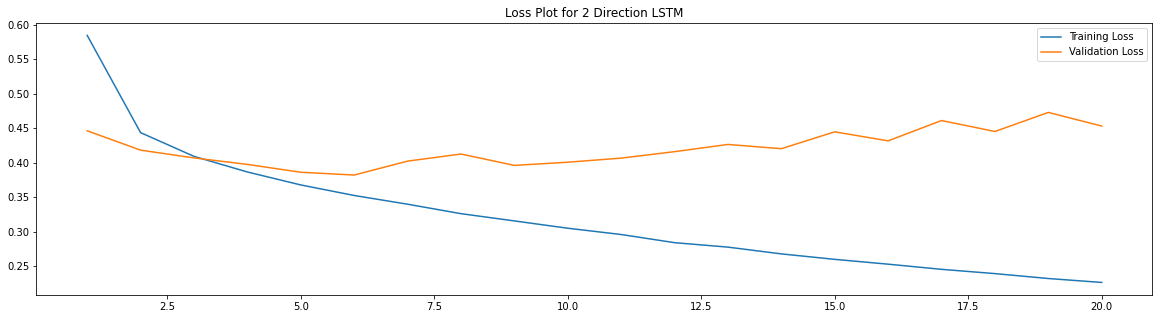

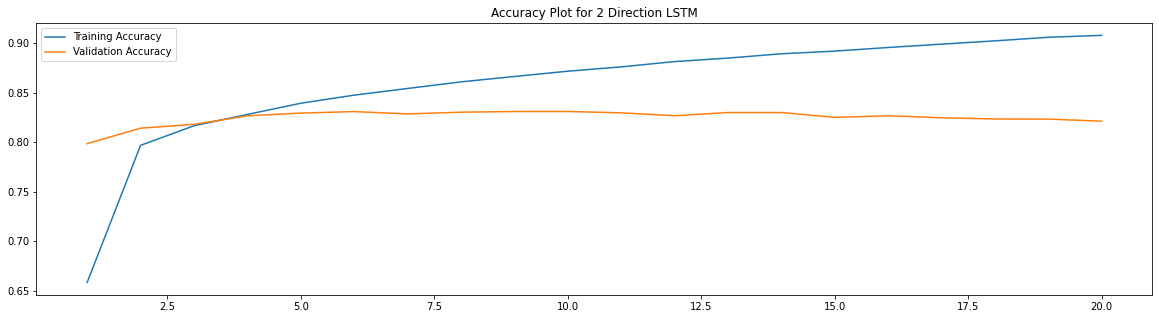

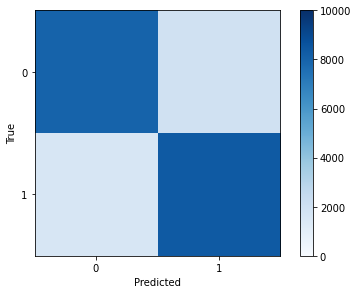

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_losses, label='Validation Loss')
plt.title('Loss Plot for 2 Direction LSTM')
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), train_accs, label='Training Accuracy')
plt.plot(np.linspace(1, NUM_EPOCHS, NUM_EPOCHS), val_accs, label='Validation Accuracy')
plt.title('Accuracy Plot for 2 Direction LSTM')
plt.legend()
plt.show()

print_confusion_matrix(model, test_iterator, 2)

#### Bert Model

In [ ]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

In [ ]:
class BERT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        self.dropout = nn.Dropout()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

    def forward(self, text):
        out = self.bert(text)

        return out

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = False
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BERT(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)


# pretrained_embeddings = TEXT.vocab.vectors
optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
for batch in train_iterator:

    if batch.label.shape[0]!=128:
      continue
    text, text_lengths = batch.text
    text = text.permute(1,0)
    text_lengths = text_lengths.cpu()
    print(text.shape)

    predictions = model(text).squeeze(1)
    print(predictions.shape)
    preds = torch.round(torch.sigmoid(predictions))
    cls_true.append(batch.label)
    cls_pred.append(preds)
    break